In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.util import montage as montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
cxr_paths = glob(os.path.join('../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet', '*', '*.png'))
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path)),
               os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 138 ../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0056_0.png
('../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0056_0.png', ['../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0056_0.png', '../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0056_0.png'])


In [8]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

In [9]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
    img_vol += [imread(img_path)]    
    seg_vol += [np.max(np.stack([imread(s_path, apply_clahe = False) for s_path in s_paths],0),0)]
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 138/138 [13:00<00:00,  5.66s/it]

Images (138, 512, 512, 1) Segmentations (138, 512, 512, 1)


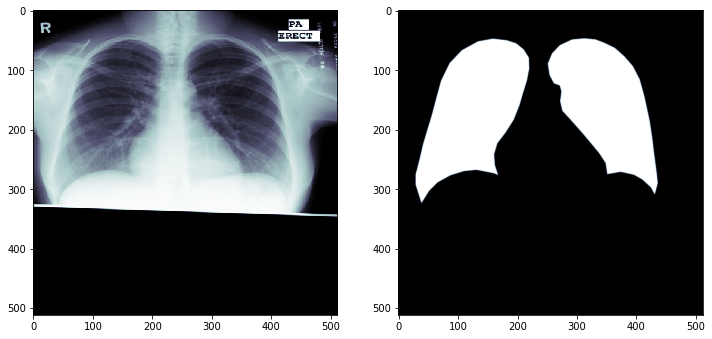

In [10]:
np.random.seed(69420)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

Train (110, 512, 512, 1) Test (28, 512, 512, 1) -0.08001929541674715 1.0
Seg (110, 512, 512, 1) 1.0 [0. 1.]


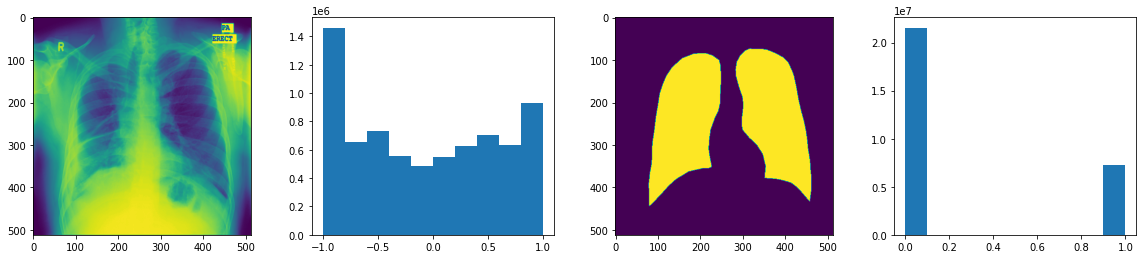

In [11]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol>127).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel());

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_vol[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_seg[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')